In [25]:
from sklearn.datasets import fetch_mldata
import pickle

### download and save data in ~/scikit_learn_data/mldata

In [26]:
mnist = fetch_mldata('MNIST original')

In [27]:
X,y=mnist["data"],mnist["target"]

In [28]:
X.shape

(70000, 784)

In [29]:
y.shape

(70000,)

### Plot and see a random image

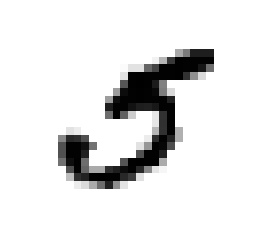

In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=X[36000]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [31]:
print(some_digit)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  86 131 225
 225 225   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  13  73 197 253 252 252 252 252   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   4  29  29 154 187 252 252 253
 252 252 233 145   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  29 252 253 252 252 252 252 253 204 112  3

In [32]:
y[36000]

5.0

In [33]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Shuffle the data set

In [34]:
import numpy as np
shuffle_index=np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

### Creating a 5 cliassifier which tells if a number is 5 or not

In [35]:
y_train_5 = ( y_train == 5 )
y_test_5 = (y_test == 5)

In [36]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [37]:
sgd_clf.predict([some_digit])

array([False])

### Inbuild and good v/s bad classifier validation
probablity of 5 is 10%, so if classifier always says No, it is correct 90% of time

##### Good

In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.93675, 0.96905, 0.92335])

##### Bad

In [39]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9129 , 0.90965, 0.9064 ])

##### Good Similar to cross_val_score

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_folds=X_train[test_index]
    y_test_folds=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_folds)
    n_corrext=sum(y_pred == y_test_folds)
    print(n_corrext/len(y_pred))

0.93675
0.96905
0.92335


### Confusion Matrix
check how much the model is confused

In [41]:
#cross val predictions for each fold
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[51903,  2676],
       [  741,  4680]])

Above numbers are:
```
True Negatives  | False Postitives
----------------------------------
False Negatives | True Postitives
```

### Precision v/s recall

* Precision: TP/(TP+FP)
like what percent of things it says positive are actually positive
`or how correct it is`
or a metrix related to `how many negatives are shown as positives`
* Recall: TP/(TP+FN)
like what percent of things are included in positive result out of all positives
`or how many 5s it detects`
or a metrix related to `how many positives are shown as negatives`

In [43]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.636215334420881

In [44]:
recall_score(y_train_5,y_train_pred)

0.8633093525179856

##### harmonic Mean - f1 score
* Gives more stress on the smaller values
* Only gets high if both values are high
F1=2/((1/precision)+(1/recall))
= 2*(precision x recall)/(precision + recall)
= TP / (TP + (FN+FP)/2)

##### F1 = 
\begin{equation*}
\frac{2}{(\frac{1}{precision}+\frac{1}{recall})} 
\end{equation*}
OR
\begin{equation*}
2\times\frac{precision \times recall}{precision + recall}
\end{equation*}
OR
\begin{equation*}
\frac{TP} {TP + \frac{FN+FP}{2}}
\end{equation*}

In [45]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325663301244424

[-448.72838747]
[False]


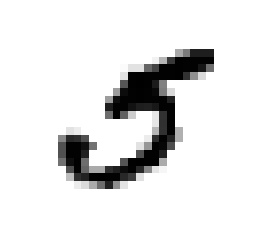

[False]


In [51]:
y_scores=sgd_clf.decision_function([some_digit])
print(y_scores)
threshold=0
y_some_digit_pred=(y_scores>threshold)
print(y_some_digit_pred)
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
print(sgd_clf.predict([some_digit]))

#### Calculate Y Scores

In [52]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

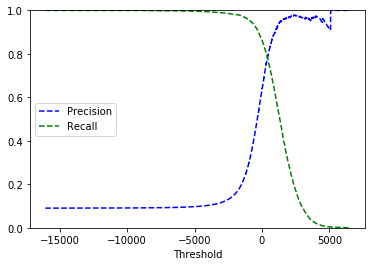

In [73]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    plt.show()
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

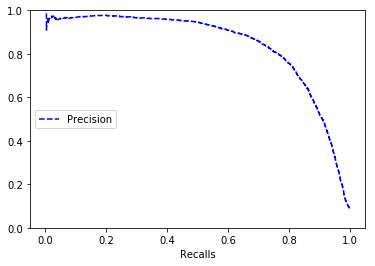

In [61]:
def plot_precision_vs_recall(precisions,recalls,thresholds):
    plt.plot(recalls,precisions,"b--",label="Precision")
    plt.xlabel("Recalls")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    plt.show()
plot_precision_vs_recall(precisions,recalls,thresholds)

In [80]:
y_train_pred_90=y_scores>1000
print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9059569773855488
0.6059767570558937


### ROC Curve
True Positive v/s False Positive curve
> also shown is the relationship between TPR and FPR, more the TPR, more the FPR

In [81]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

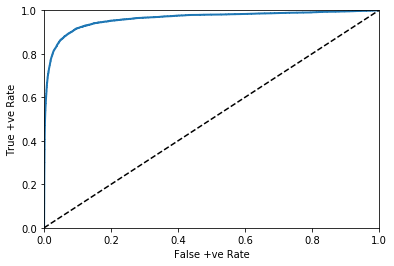

In [84]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr,linewidth=2)
    plt.plot([0,1],[0,1],"k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False +ve Rate")
    plt.ylabel("True +ve Rate")
    plt.show()
plot_roc_curve(fpr,tpr)

##### Area under the curve
for perfect, its 1, for pure random, its .5

In [85]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9615937876862805

### Compare RandomForestClassifier to SGDClassifier

In [86]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [87]:
y_scores_forest=y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

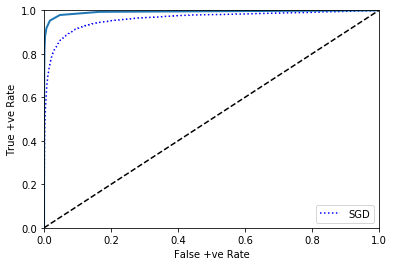

In [91]:
def plot_fpr_tpr(fpr,tpr,fpr_forest,tpr_forest):
    plt.plot(fpr,tpr,"b:",label="SGD")
    plt.legend(loc="lower right")
    plot_roc_curve(fpr_forest,tpr_forest) # the function i wrote calls show method
plot_fpr_tpr(fpr,tpr,fpr_forest,tpr_forest)

In [92]:
roc_auc_score(y_train_5,y_scores_forest)

0.9927645941206774

### Multi Class Classification

##### SGD does one vs all by default if we have multiple training classes

In [93]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [94]:
sgd_clf.predict([some_digit])

array([3.])

In [96]:
some_digit_scores=sgd_clf.decision_function([some_digit])

In [97]:
np.argmax(some_digit_scores)

3

In [98]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

##### scikit learn has a way to force one-versus-one v/s one-versus-all classifiers
just pass the classifier inside `OneVsOneClassifier` or `OneVsRestClassifier` classes

In [101]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=1000))
ovo_clf.fit(X_train,y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5.]
45


##### Random Forest

In [102]:
forest_clf.fit(X_train,y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[5.]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


##### Evaluating Accuracy

In [103]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.88807239, 0.86539327, 0.83167475])

##### Strategy to improve the results
> Scale the inputs

In [104]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.905019  , 0.89789489, 0.90503576])

### Error Analysis

In [105]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5608,    0,   14,    5,    8,   46,   33,    6,  201,    2],
       [   1, 6427,   44,   19,    3,   45,    5,    8,  177,   13],
       [  27,   26, 5281,   90,   75,   22,   70,   36,  320,   11],
       [  34,   22,  111, 5259,    2,  216,   26,   44,  352,   65],
       [  12,   16,   38,   12, 5268,   10,   43,   17,  262,  164],
       [  31,   17,   31,  169,   56, 4484,   81,   19,  463,   70],
       [  31,   19,   48,    2,   43,   92, 5566,    5,  112,    0],
       [  17,   15,   56,   29,   45,   10,    4, 5736,  128,  225],
       [  20,   65,   45,   99,    2,  136,   35,   11, 5387,   51],
       [  24,   25,   31,   66,  129,   35,    1,  189,  306, 5143]])

##### Plotting the confusion matrix for easier analysis

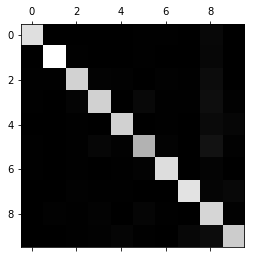

In [106]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

##### focusing on error rates


In [107]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

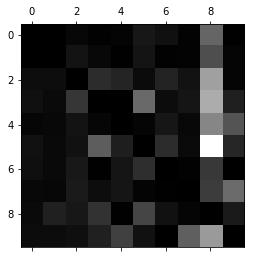

In [109]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

##### Analyzing 3s and 5s

In [147]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

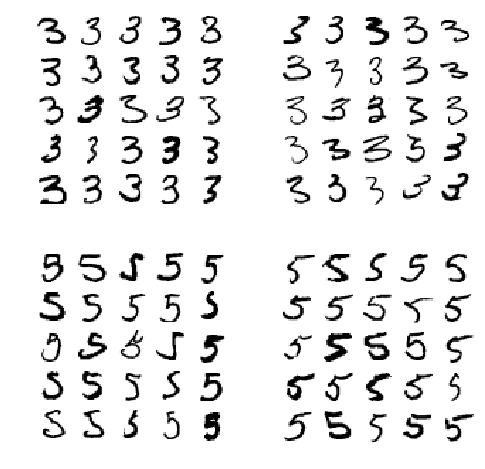

In [130]:
cl_a,cl_b=3,5
X_aa=X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b) & (y_train_pred==cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()

### MultiLabel Classification

In [116]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large=(y_train >=7)
y_train_odd=(y_train%2 == 1)
y_multilabel=np.c_[y_train_large,y_train_odd]

In [117]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [118]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [119]:
Y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)

NameError: name 'y_train_knn_pred' is not defined

In [121]:
f1_score(y_multilabel,Y_train_knn_pred,average="macro")

0.977270725222446

This assumes, each variable is equally important.
A simple option to solve this is giving each label a weight equal to its support, ie number of instances with that target label by doing `average="weighted"`

In [122]:
f1_score(y_multilabel,Y_train_knn_pred,average="weighted")

0.9786037593431536

### Multi Output Classification

##### Introduce some noise in digits and save them
we will produce one label per pixel, with each label having multiple values(0-255)

In [132]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod=X_train
y_test_mod=X_test

In [134]:
knn_clf.fit(X_train_mod,y_train_mod)

In [154]:
some_index=4500
noisy_digit=(X_test_mod[some_index])
clean_digit=knn_clf.predict([noisy_digit])


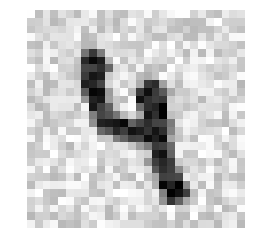

In [155]:
plot_digit(noisy_digit)

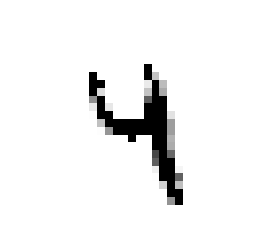

In [156]:
plot_digit(clean_digit)